# Deep Q-Learning

In this lecture we will use Deep Q-learning to learn a policy to solve a simulator in the Open AI Gym.

# Clones, Installs, Imports

## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [1]:
!git clone https://github.com/zlisto/reinforcement_learning_tutorial

import os
os.chdir("reinforcement_learning_tutorial")

Cloning into 'reinforcement_learning_tutorial'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 40 (delta 12), reused 35 (delta 7), pack-reused 0
Unpacking objects: 100% (40/40), done.


## Install Packages

In [2]:
!pip install gym pyvirtualdisplay  Box2D box2d-py
!apt-get install -y xvfb python-opengl ffmpeg 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.3 MB/s 
     |████████████████████████████████| 448 kB 72.6 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,281 kB of archives.
After this operation, 7,687 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.11 [785 kB]
Fetched 1,281 kB in

## Import Librarires



In [3]:
from scripts.rl_helper import *

import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay



import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import base64, io

from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob


display = Display(visible=0, size=(1400, 900))
display.start()

# Simulator Environment
Set the name of the simulator environment to a variable `env_name`.  We can load the simulator environment with the `gym.make` function.  We use the `wrap_env` function so we can visualize the output of the simulator in Colab.  

Note: You can load many different gym simulator environments with this line of code.  Just change `env_name`.  You can find a list of the gym environments here: https://www.gymlibrary.ml/

## Load Environment

In [52]:
env_name = "LunarLander-v2"
#env_name = "Acrobot-v1"
#env_name = "MountainCar-v0"
#env_name = "CartPole-v1"

## Run Environment


In [53]:
env = wrap_env(gym.make(env_name))

observation = env.reset()
score = 0
step = 0
while True:
    env.render()
    step+=1
    # your agent goes here
    action = env.action_space.sample()
    
    observation, reward, done, _ = env.step(action)
    score+=reward
    if done:
        break
print(f"{env_name} Score = {score}, Steps = {step}")
env.close()
show_video()


  



CartPole-v1 Score = 12.0, Steps = 12


# Deep Q-Learning

We wil train an agent to solve the mountain car using Q-learning.  We will make a Q-table, which is a tensor (a high dimensional matrix) indexed by the states and actions.  The value in each cell of the table equals the rewards that will be achieved if one takes the action when in the given state, and then play the game perfectly.  Q-learning lets us update the values in this table as we play to learn the right policy.  

When we are done, we will have the tensor `Q` which is the Q-table.  To use this table, in each step of the simulator, we check what state we are in.  Then, we look up this row in the table, and choose the action in this row with the highest value.

## Initialize Parameters

We choose a few parameters for Deep Q-learning.


In [20]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

## Neural Network Architecture

We define a class `QNetwork` which contains the architecture of the neural network we will use to represent the Q-table.

In [21]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

## Use a GPU

A GPU makes training the neural network much faster.  We define `device` as the processor we are using.  It is either `cpu` or `cuda:0` (a GPU).

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device = {device}")

Device = cuda:0


## Agent Class

We define a class `Agent` that contains a lot of the functionality needed for Deep Q-Learning.  In particular, it has methods for

1.  `step` - advance the simulator environment one step and then call the `learn` function to update local Q-network parameters.

2. `act` - take an action in the simulator using the local Q-network.

3. `learn` - update the local Q-network parameters using the Q-learning algorithm combined with back-propagation (derivative with respect to neural network parameters).





In [23]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Define Replay Buffer

We save each step we take in the simulator in the replay buffer.  Then when we update the local Q-network parameters, we sample a batch of random steps from this buffer, and use these to update.

In [24]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## DQN Function

The function `dqn` will run the deep Q-learning loop.  It takes the following inputs:

1. `n_episodes` (int): maximum number of training episodes

2. `max_t` (int): maximum number of timesteps per episode
        
3. `eps_start` (float): starting value of epsilon, for epsilon-greedy action selection
        
4. `eps_end` (float): minimum value of epsilon
        
5. `eps_decay` (float): multiplicative factor (per episode) for decreasing epsilon

In [56]:
def dqn(fname,score_win, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        avg_score = np.mean(scores_window)  #avg score of last 100 episodes
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}', end="")
        
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}')
        
        if np.mean(scores_window)>=score_win:            
            print(f"\nEnvironment solved in {i_episode-100:d} episodes!")
            print(f"\tAverage Score: {avg_score:.2f}")
            torch.save(agent.qnetwork_local.state_dict(), fname)
            break
    torch.save(agent.qnetwork_local.state_dict(), fname)
    return scores



# Train Agent

## Initialize the Agent

In [54]:
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"{num_states} dimension state space")
print(f"{num_actions} dimension action space")

agent = Agent(state_size=num_states, action_size=num_actions, seed=0)


4 dimension state space
2 dimension action space


## Run DQN

In [58]:
fname = f'{env_name}_checkpoint.pth'
score_win = 490
n_episodes=2000
scores = dqn(fname, score_win,n_episodes=2000)

Episode 100	Average Score: 34.34
Episode 200	Average Score: 152.45
Episode 300	Average Score: 304.71
Episode 400	Average Score: 384.01
Episode 500	Average Score: 474.91
Episode 532	Average Score: 491.73
Environment solved in 432 episodes!
	Average Score: 491.73


## Plot Rewards vs. Episode

We make a column of the moving average of the rewards using the `rolling` and `mean` functions on the `reward` column of the dataframe.

In [59]:
# Plot Rewards
mavg = 100 #number of episodes to avg rewards over
df = pd.DataFrame({'episode':list(range(len(scores))), 
                   'score':scores})
df[f'score_{mavg}mavg'] = df.score.rolling(100).mean()


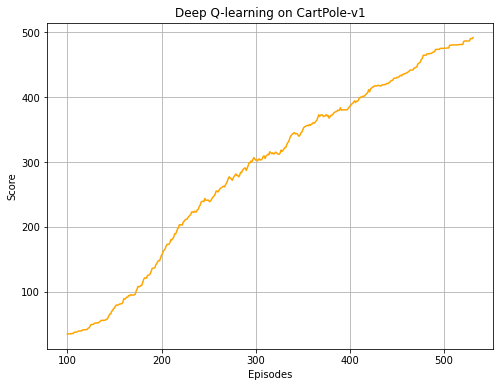

In [60]:
fig = plt.figure(figsize = (8,6))
sns.lineplot(data = df[mavg:], x='episode', 
             y = f'score_{mavg}mavg',
            color = 'orange')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title(f'Deep Q-learning on {env_name}')
plt.grid()
plt.show()

# Test Trained Agent



In [61]:
fname = f'{env_name}_checkpoint.pth'
env = wrap_env(gym.make(env_name))

num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"{num_states} dimension state space")
print(f"{num_actions} dimension action space")

agent = Agent(state_size=num_states, action_size=num_actions, seed=0)

agent.qnetwork_local.load_state_dict(torch.load(fname))

4 dimension state space
2 dimension action space


<All keys matched successfully>

In [62]:
env = wrap_env(gym.make(env_name))

state = env.reset()
score = 0
step = 0
while True:
    env.render()
    step+=1
    # your agent goes here
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    score+=reward
    if done:
        break
print(f"{env_name} Score = {score}, Steps = {step}")
env.close()
show_video() 





CartPole-v1 Score = 500.0, Steps = 500
